In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
class CFDDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [31]:
data_dir = '/Volumes/easystore/ansys-pulsatile/MRM additional CFD/patient 8/patient_8_files/dp0/FFF/Fluent'
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

data_list = []
for file in csv_files:
    df = pd.read_csv(file)
    data_list.append(df[['      x-velocity', '      y-velocity', '      z-velocity', '        pressure']].values)

data = np.vstack(data_list)
X = data[:, :3]
y = data[:, 3]

import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump((X, y), f)

In [4]:
y.shape

(46631280,)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [6]:
train_dataset = CFDDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = CFDDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = CFDDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16))
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/2], Train Loss: 3148016.3358, Val Loss: 3047028.0934
Epoch [2/2], Train Loss: 3038042.1369, Val Loss: 3023913.6042


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        targets.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)

print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')

Test MSE: 3014115.2500
Test MAE: 954.7390


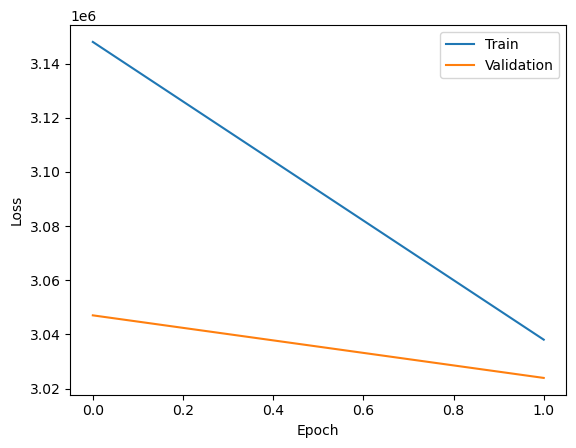

In [19]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Text(0.5, 1.0, 'ROC Curve (threshold=1000)')

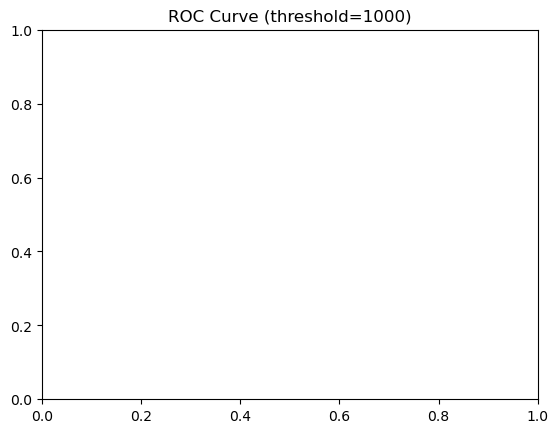

In [26]:
fpr, tpr, thresholds = roc_curve(binary_targets, predictions)
plt.title(f'ROC Curve (threshold={threshold})')


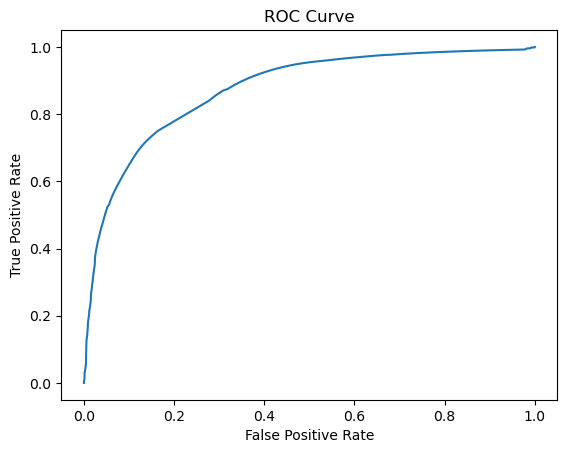

In [27]:
from sklearn.metrics import roc_curve

# set threshold value
threshold = 1000

# create binary targets
binary_targets = (targets > threshold).astype(int)

fpr, tpr, thresholds = roc_curve(binary_targets, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

